### 1. Define functions

In [13]:
import os
from sklearn.model_selection import train_test_split
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments, pipeline
import torch
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import re
import pickle

function to fetch files with given extension \
I remove multi-line comments because they are mostly unnecessary

In [2]:
def extract_kotlin_files(source_dir, extension='.kt'):
    code = []
    comment_pattern = re.compile(r'/\*.*?\*/', re.DOTALL)

    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if file.endswith(extension):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    file_content = f.read()
                    file_content = re.sub(comment_pattern, '', file_content)
                    code.append(file_content.strip())
    return code

In [3]:
def save_data(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

split data to train/test set

In [4]:
def split_data(dataset):
    train_files, test_files = train_test_split(dataset, test_size=0.2, random_state=42)
    valid_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)
    return (train_files, test_files, valid_files)

model train

In [5]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = item['input_ids'].clone()
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [6]:
def plot_loss(results):
    plt.figure(figsize=(10, 5))
    plt.plot(results['train_loss'], label='Train Loss')
    plt.plot(results['validation_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.show()

In [11]:
def fine_tune_model(train_dataset, valid_dataset, model_name="microsoft/phi-1_5"):
    model = AutoModelForCausalLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    print("Model and tokenizer loaded.")

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    train_encodings = tokenizer(train_dataset, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
    valid_encodings = tokenizer(valid_dataset, truncation=True, padding="max_length", max_length=512, return_tensors="pt")

    train_dataset = MyDataset(train_encodings)
    valid_dataset = MyDataset(valid_encodings)
    print("Datasets prepared for training.")

    training_args = TrainingArguments(
        output_dir='./results',
        evaluation_strategy='steps',
        eval_steps=10,
        save_strategy='steps',
        save_steps=10,
        num_train_epochs=5,
        per_device_train_batch_size=16,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss',
        greater_is_better=False,
        fp16=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset
    )

    trainer.train()

    train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
    validation_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
    results = {
        'train_loss': train_loss,
        'validation_loss': validation_loss
    }
    plot_loss(results)
    
    return model, tokenizer

In [8]:
def save_model_and_tokenizer(model, tokenizer, model_path="model", tokenizer_path="tokenizer"):
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(tokenizer_path)

### 2. Run code

extract kotlin and python files

In [9]:
kotlin_files = extract_kotlin_files("/path_to_open_source_project")
print(len(kotlin_files))
train_files, test_files, valid_files = split_data(kotlin_files)
save_data(test_files, 'kotlin_files.pkl')

295
84


Train model

Model and tokenizer loaded.
Datasets prepared for training.


  0%|          | 0/70 [00:00<?, ?it/s]

{'loss': 3.194, 'grad_norm': 20.9370059967041, 'learning_rate': 6.000000000000001e-07, 'epoch': 0.68}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 3.3363897800445557, 'eval_runtime': 0.5139, 'eval_samples_per_second': 56.426, 'eval_steps_per_second': 29.186, 'epoch': 0.68}
{'loss': 3.0607, 'grad_norm': 38.99574279785156, 'learning_rate': 1.6000000000000001e-06, 'epoch': 1.36}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 3.0876760482788086, 'eval_runtime': 0.5178, 'eval_samples_per_second': 56.009, 'eval_steps_per_second': 28.97, 'epoch': 1.36}
{'loss': 2.753, 'grad_norm': 7.742048740386963, 'learning_rate': 2.6e-06, 'epoch': 2.03}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 2.7378695011138916, 'eval_runtime': 0.5144, 'eval_samples_per_second': 56.376, 'eval_steps_per_second': 29.16, 'epoch': 2.03}
{'loss': 2.5876, 'grad_norm': 9.040217399597168, 'learning_rate': 3.6e-06, 'epoch': 2.71}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 2.4059526920318604, 'eval_runtime': 0.4938, 'eval_samples_per_second': 58.727, 'eval_steps_per_second': 30.376, 'epoch': 2.71}
{'loss': 2.2453, 'grad_norm': 11.84791374206543, 'learning_rate': 4.6e-06, 'epoch': 3.39}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 2.008647918701172, 'eval_runtime': 0.536, 'eval_samples_per_second': 54.101, 'eval_steps_per_second': 27.983, 'epoch': 3.39}
{'loss': 2.0698, 'grad_norm': 3.609308958053589, 'learning_rate': 5.600000000000001e-06, 'epoch': 4.07}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 1.733956217765808, 'eval_runtime': 0.4898, 'eval_samples_per_second': 59.203, 'eval_steps_per_second': 30.622, 'epoch': 4.07}
{'loss': 1.9414, 'grad_norm': 2.582919120788574, 'learning_rate': 6.6e-06, 'epoch': 4.75}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 1.6456514596939087, 'eval_runtime': 0.4824, 'eval_samples_per_second': 60.119, 'eval_steps_per_second': 31.096, 'epoch': 4.75}


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


{'train_runtime': 76.8788, 'train_samples_per_second': 15.349, 'train_steps_per_second': 0.911, 'train_loss': 2.5502408163888113, 'epoch': 4.75}


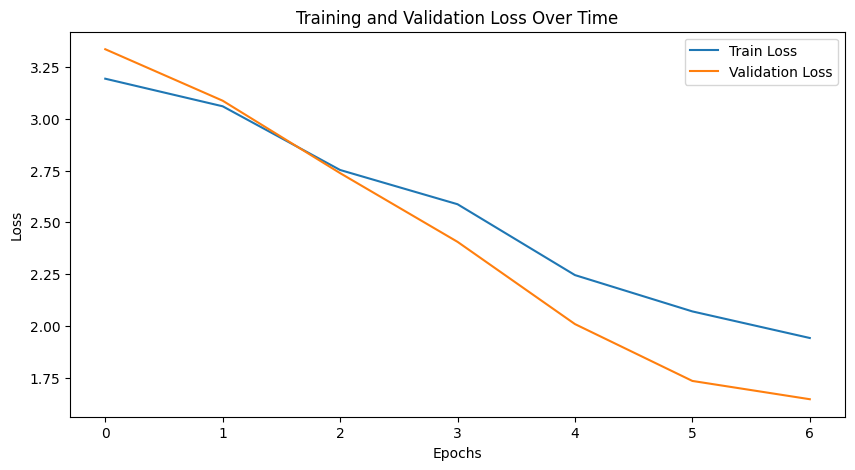

In [14]:
model, tokenizer = fine_tune_model(train_files, valid_files)

In [15]:
save_model_and_tokenizer(model, tokenizer)